<a href="https://colab.research.google.com/github/N1colasFD/Unir_CODES/blob/main/Outliers_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

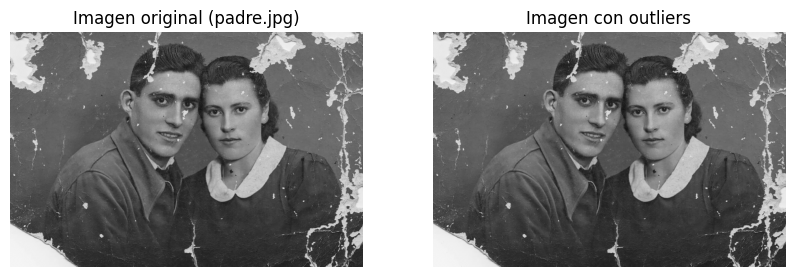

In [9]:
# a) Imporatamos las librerias

import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from skimage import io
from skimage import color

#cargar la imagen

img = io.imread('/content/otra.jpg')

img = color.rgb2gray(img)
rng = np.random.default_rng(42)

# semilla reproducible

H, W = img.shape
K = 200

# índices lineales únicos sin reemplazo
idx = rng.choice(H*W, size=K, replace=False)
ys, xs = np.unravel_index(idx, (H, W))

img_outliers = img.copy()
vals = img[ys, xs]
img_outliers[ys, xs] = np.where(vals < 0.1, 2.0, 0.5) # Use 0.5 as threshold for float grayscale image

# Display results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title("Imagen original (padre.jpg)")
axes[0].axis("off")

axes[1].imshow(img_outliers, cmap='gray')
axes[1].set_title("Imagen con outliers")
axes[1].axis("off")

plt.show()

In [10]:
"""
Outliers (ruido impulsivo / sal-y-pimienta): diagnóstico y corrección
Ejecutable en Google Colab o Jupyter. SOLO para OUTLIERS.

Qué hace:
- Detecta outliers combinando:
  (a) extremos cercanos a 0 o 1 (eps=0.02), y
  (b) umbral robusto en el residuo con MAD: |r - med(r)| > k * σ̂, σ̂ = MAD/0.6745.
- Corrige SOLO los píxeles atípicos con mediana local (3→5→7), sin suavizar toda la imagen.
- Muestra: entrada, máscara, corregida e histogramas antes/después.

Requisitos: cv2 (OpenCV), numpy, matplotlib
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# Utilidades
# -----------------------------

def to_gray01(path):
    """
    Lee una imagen (BGR) y devuelve:
      - GRAY float32 en [0,1]
      - BGR original (uint8)
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"No se pudo cargar la imagen: {path}")
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    return gray.astype(np.float32) / 255.0, bgr


def residual(img01):
    """
    Residuo = imagen - blur suave (3x3).
    Alta frecuencia ≈ ruido/impulsos/detalle fino.
    """
    return img01 - cv2.GaussianBlur(img01, (3,3), 0)


def mad_sigma(x):
    """
    Estimación robusta de σ̂ a partir del residuo: σ̂ ≈ MAD/0.6745
    (MAD = mediana(|x - mediana(x)|))
    """
    r = x.ravel().astype(np.float32)
    med = np.median(r)
    MAD = np.median(np.abs(r - med))
    return float(MAD / 0.6745 + 1e-8)


def fraction_of_extremes(img01, eps=0.02):
    """
    Fracción de píxeles en extremos [0, eps) ∪ (1-eps, 1].
    Indicio de outliers (impulsos).
    """
    return float((img01 < eps).mean() + (img01 > 1-eps).mean())

In [11]:
# -----------------------------
# Detección y corrección OUTLIERS
# -----------------------------

def detect_outliers_mask(img01, k=3.0, eps=0.02):
    """
    Máscara de outliers combinando:
      - Extremos globales (cerca de 0/1) con margen eps.
      - Z-score robusto en el residuo: |r - med(r)| > k · σ̂
    Devuelve: mask(bool), resid, sigma_hat, stats(dict)
    """
    r = residual(img01)
    s = mad_sigma(r)
    m_ext = (img01 < eps) | (img01 > 1-eps)
    m_rob = np.abs(r - np.median(r)) > (k * s)
    mask = (m_ext | m_rob)
    stats = {"sigma_hat": s, "extreme_frac": float(m_ext.mean()), "k": k, "eps": eps}
    return mask, r, s, stats


def replace_with_local_median(img01, mask, wins=(3,5,7)):
    """
    Reemplaza SOLO los píxeles marcados por la mediana local.
    Secuencia 3→5→7 si aún persisten (preserva bordes).
    """
    out = img01.copy()
    x8 = (out*255).astype(np.uint8)
    for w in wins:
        med = cv2.medianBlur(x8, w).astype(np.float32)/255.0
        out[mask] = med[mask]
        x8 = (out*255).astype(np.uint8)
    return np.clip(out, 0, 1)

In [12]:
'''# -----------------------------
# (Opcional) Versión para color
# -----------------------------

def replace_with_local_median_color(bgr, mask, wins=(3,5,7)):
    """
    Aplica la misma idea a color: corrige SOLO en máscara, canal por canal.
    """
    out = bgr.copy()
    mask3 = np.repeat(mask[..., None], 3, axis=2)
    for w in wins:
        med = cv2.medianBlur(out, w)
        out[mask3] = med[mask3]
    return out'''


# -----------------------------
# (Opcional) Simular outliers
# -----------------------------

def simulate_outliers(img01, K=300, seed=42):
    """
    Inyecta K impulsos 0/1 aleatorios en una imagen [0,1].
    Útil para documentar el caso en el informe.
    """
    rng = np.random.default_rng(seed)
    H, W = img01.shape
    K = min(K, H*W)
    idx = rng.choice(H*W, size=K, replace=False)
    vals = img01.ravel()[idx]
    sp = img01.copy().ravel()
    # Si el valor es bajo, sube a 1.0 (sal); si es alto, baja a 0.0 (pimienta).
    sp[idx[vals < 0.5]] = 1.0
    sp[idx[vals >= 0.5]] = 0.0
    return sp.reshape(H, W)


In [14]:
# -----------------------------
# DEMO (main)
# -----------------------------

def run_demo(image_path="/content/Tranvia.jpg", simulate=False, K=300, show_color=False):
    """
    Ejecuta el pipeline SOLO para OUTLIERS sobre la imagen dada.
      - simulate=True inyecta outliers para probar.
      - show_color=True aplica corrección también a la imagen color.
    """
    img01, bgr = to_gray01(image_path)
    test = simulate_outliers(img01, K=K) if simulate else img01

    mask, r, s, stats = detect_outliers_mask(test, k=3.0, eps=0.02)
    corrected = replace_with_local_median(test, mask, wins=(3,5,7))

    print(f"σ̂(residuo) = {s:.4f}  (~ {s*255:.1f} niveles 8-bit)")
    print(f"Fracción de extremos = {stats['extreme_frac']*100:.2f}%  |  k={stats['k']}  eps={stats['eps']}")
    print(f"Pixeles marcados como outliers: {mask.sum()}  ({mask.mean()*100:.2f} % de la imagen)")

    # Visualización: entrada, máscara, corregida (GRIS)
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(test, cmap='gray'); plt.title('Entrada'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title('Máscara de outliers'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(corrected, cmap='gray'); plt.title('Corregida (mediana local)'); plt.axis('off')
    plt.tight_layout(); plt.show()

    # Histogramas antes/después (GRIS)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(test.ravel(), bins=256, range=(0,1), density=True); plt.title('Hist intensidades (entrada)')
    plt.subplot(1,2,2); plt.hist(corrected.ravel(), bins=256, range=(0,1), density=True); plt.title('Hist intensidades (corregida)')
    plt.tight_layout(); plt.show()

 # (Opcional) Corregir también la imagen color, aplicando máscara
    if show_color:
        out_color = replace_with_local_median_color(bgr, mask, wins=(3,5,7))
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); plt.title('Color (original)'); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(out_color, cv2.COLOR_BGR2RGB)); plt.title('Color (corregida en máscara)'); plt.axis('off')
        plt.tight_layout(); plt.show()


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 34)

In [ ]:
run_demo("/content/Tranvia.jpg", simulate=False, K=800, show_color=False)

# imagen está muy “limpia”, simular outliers:
#run_demo("/content/Tranvia.jpg", simulate=True, K=300, show_color=False)

# (Opcional) Ver versión en color (corrige solo en la máscara de outliers)

#run_demo("/content/Tranvia.jpg", simulate=False, K=400, show_color=True)

In [ ]:
# Cambia la ruta a tu imagen
run_demo("/content/Tranvia.jpg", simulate=False, K=300, show_color=False)
